<div style="background-color:lightgreen; border-style: dotted;border-color: yellow;text-align:center;color:blue;font-size:20px;border-radius: 50px;padding: 20px 20px;"><strong> Gashaw M. Goshu, PhD in Chemistry</strong></div>

# HOMO-LUMO Energy Gap Prediction using RDKit Molecular descriptors<br>
<b>HOMO</b> stands for <i>highest occupied molecular orbital</i> and <b>LUMO</b> stands for <i> lowest unoccupied molecular orbital</i>. HOMO-LUMO molecular orbitals are called frontier molecular orbitals. They are involved in chemical bond formation. Especially, pericyclic reactions such as cycloaddition, electrocyclic reactions, and sigmatropic rearrangement are explained using HOMO-LUMO molecular orbitals. In addition, in UV-Visible spectroscopy, the absorbance of organic molecules that have extended conjugated double bonds can be rationalized using the HOMO-LUMO energy gap of the molecules.
<div>
    <img src="plainHOMO-LUMOEnegygap .jpg" width="400")>
</div>

In [1]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
#----------------------------------------------------
import pandas as pd
import numpy as np
#----------------------------------------------------
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
#----------------------------------------------------
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn
#----------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [2]:
import session_info
session_info.show()

# Part I - This was already discussed before. Here is the link for the youtube video [the molecular descriptors](https://www.youtube.com/watch?v=9i9SY6Nd1Zw&t=122s). I will also put it in the description.

In [3]:
# https://zivgitlab.uni-muenster.de/m_kueh11/fp-dm-tool
# It was an excel file, but converted it to csv file 
# It is the energy gap between HOMO-LUMO
# https://www.sciencedirect.com/science/article/pii/S2451929420300851

dataset = pd.read_csv('D:\Orbital_Energies_input_data.csv')
dataset.shape

(2904, 2)

In [4]:
dataset.head()

,SMILES,Energygap
0,Cc1ccc(cc1)C(F)(F)F,197.749421
1,OC(=O)CCCCl,247.493942
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.712327
3,Nc1ccc(Cl)c(Cl)c1,169.027707
4,C[C@@H](CCO)CCC=C(C)C,209.569808


## 1. Generate canonical SMILES

In [5]:
# There might be one or more valid SMILES that can represent one compound
# Thanks to Pat Walters this information:
# https://www.blogger.com/profile/18223198920629617711
def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles] 
    smiles = [Chem.MolToSmiles(mol) for mol in mols]
    return smiles

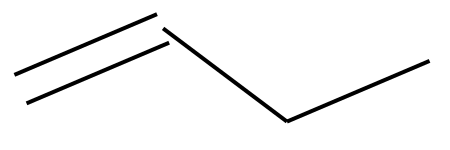

In [6]:
a = Chem.MolFromSmiles('C=CCC')
a

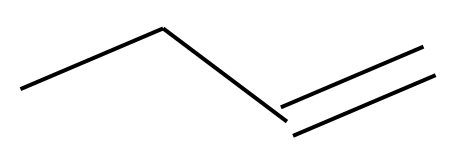

In [7]:
b = Chem.MolFromSmiles('CCC=C')
b

In [8]:
a==b

False

In [9]:
c = canonical_smiles(['C=CCC'])
c

['C=CCC']

In [10]:
d = canonical_smiles(['CCC=C'])
d

['C=CCC']

In [11]:
c==d

True

In [12]:
# Canonical SMILES
Canon_SMILES = canonical_smiles(dataset.SMILES)
len(Canon_SMILES)

2904

In [13]:
# Put the smiles in the dataframe
dataset['SMILES'] = Canon_SMILES
dataset

,SMILES,Energygap
0,Cc1ccc(C(F)(F)F)cc1,197.749421
1,O=C(O)CCCCl,247.493942
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.712327
3,Nc1ccc(Cl)c(Cl)c1,169.027707
4,CC(C)=CCC[C@@H](C)CCO,209.569808
...,...,...
2899,c1ccc(P(CCP(c2ccccc2)c2ccccc2)c2ccccc2)cc1,168.649319
2900,Brc1cccc2sccc12,162.928319
2901,CCOC(=O)N1c2ccccc2C=C[C@@H]1OCC,165.098245
2902,c1ccc2sccc2c1,167.958431


In [14]:
# Create a list for duplicate smiles
duplicates_smiles = dataset[dataset['SMILES'].duplicated()]['SMILES'].values
len(duplicates_smiles)

31

In [15]:
# Create a list for duplicate smiles
dataset[dataset['SMILES'].isin(duplicates_smiles)].sort_values(by=['SMILES'])

,SMILES,Energygap
218,C1=CCCCCCC1,214.097913
2125,C1=CCCCCCC1,214.097913
1901,C1CC[C@H]2CCCC[C@@H]2C1,251.144790
552,C1CC[C@H]2CCCC[C@@H]2C1,251.144790
554,C=CN1CCCC1=O,190.834900
1808,C=CN1CCCC1=O,190.835527
2203,C=Cc1ccccc1,168.467969
1354,C=Cc1ccccc1,168.475499
2341,C=Cc1ccccc1,168.490559
1265,C=Cc1ccncc1,174.833420


## 2.  Drop duplicate values

In [16]:
dataset_new = dataset.drop_duplicates(subset=['SMILES'])
len(dataset_new)

2873

In [17]:
dataset_new

,SMILES,Energygap
0,Cc1ccc(C(F)(F)F)cc1,197.749421
1,O=C(O)CCCCl,247.493942
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.712327
3,Nc1ccc(Cl)c(Cl)c1,169.027707
4,CC(C)=CCC[C@@H](C)CCO,209.569808
...,...,...
2899,c1ccc(P(CCP(c2ccccc2)c2ccccc2)c2ccccc2)cc1,168.649319
2900,Brc1cccc2sccc12,162.928319
2901,CCOC(=O)N1c2ccccc2C=C[C@@H]1OCC,165.098245
2902,c1ccc2sccc2c1,167.958431


## Calculate descriptors using RDkit

###  General molecular descriptors-about 200 molecular descriptors

In [18]:
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles] 
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] 
                                    for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names 

# Function call
Mol_descriptors,desc_names = RDkit_descriptors(dataset_new['SMILES'])

In [19]:
df_with_200_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)
df_with_200_descriptors

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.550510,-5.076351,12.550510,1.008796,0.546828,160.138,153.082,160.049985,60,0,...,0,0,0,0,0,0,0,0,0,0
1,10.676844,-3.333333,10.676844,1.840718,0.569323,122.551,115.495,122.013457,42,0,...,0,0,0,0,0,0,0,0,0,0
2,13.050084,-4.111425,13.050084,0.722809,0.790287,361.825,341.665,361.108086,132,0,...,0,0,0,0,0,0,0,0,0,0
3,7.402685,-0.449630,7.402685,0.074321,0.582519,162.019,156.979,160.979905,48,0,...,0,0,0,0,0,0,0,0,0,0
4,8.095237,-4.484184,8.095237,1.886963,0.606746,156.269,136.109,156.151415,66,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2868,9.505488,-3.873136,9.505488,0.973292,0.373065,398.426,374.234,398.135324,138,0,...,0,0,0,0,0,0,0,0,0,0
2869,7.651157,-0.170718,7.651157,0.017477,0.625891,213.099,208.059,211.929533,50,0,...,0,0,0,0,0,0,0,1,0,0
2870,13.017078,-3.813937,13.017078,0.325694,0.823664,247.294,230.158,247.120843,96,0,...,0,0,0,0,0,0,0,0,0,0
2871,7.592407,-0.348333,7.592407,0.030556,0.519376,134.203,128.155,134.019021,44,0,...,0,0,0,0,0,0,0,1,0,0


# Part II Starts Here!!

## 1. Remove highly correlated features

In [20]:
def remove_correlated_features(descriptors):
    # Calculate correlation
    correlated_matrix = descriptors.corr().abs()

    # Upper triangle of correlation matrix
    upper_triangle = correlated_matrix.where(np.triu(np.ones(correlated_matrix.shape),k=1).astype(np.bool))

    # Identify columns that have above 0.9 values of correlation
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] >= 0.9)]
    print(to_drop)
    descriptors_correlated_dropped = descriptors.drop(columns=to_drop, axis=1)
    return descriptors_correlated_dropped    

In [21]:
descriptors_new = remove_correlated_features(df_with_200_descriptors)
descriptors_new

['MaxAbsEStateIndex', 'HeavyAtomMolWt', 'ExactMolWt', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan2', 'FpDensityMorgan3', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi3n', 'Chi4n', 'Chi4v', 'LabuteASA', 'SlogP_VSA5', 'SlogP_VSA6', 'EState_VSA1', 'VSA_EState1', 'HeavyAtomCount', 'NOCount', 'NumHAcceptors', 'NumHDonors', 'MolMR', 'fr_COO2', 'fr_C_O', 'fr_Nhpyrrole', 'fr_benzene', 'fr_nitro_arom', 'fr_phenol', 'fr_phenol_noOrthoHbond']


,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.550510,-5.076351,1.008796,0.546828,160.138,60,0,0.415910,-0.166138,1.000000,...,0,0,0,0,0,0,0,0,0,0
1,10.676844,-3.333333,1.840718,0.569323,122.551,42,0,0.302884,-0.481230,2.142857,...,0,0,0,0,0,0,0,0,0,0
2,13.050084,-4.111425,0.722809,0.790287,361.825,132,0,0.346953,-0.478304,1.120000,...,0,0,0,0,0,0,0,0,0,0
3,7.402685,-0.449630,0.074321,0.582519,162.019,48,0,0.156217,-0.398685,1.222222,...,0,0,0,0,0,0,0,0,0,0
4,8.095237,-4.484184,1.886963,0.606746,156.269,66,0,0.210037,-0.396366,1.454545,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2868,9.505488,-3.873136,0.973292,0.373065,398.426,138,0,0.062956,-0.062223,0.357143,...,0,0,0,0,0,0,0,0,0,0
2869,7.651157,-0.170718,0.017477,0.625891,213.099,50,0,0.073986,-0.143780,1.200000,...,0,0,0,0,0,0,0,1,0,0
2870,13.017078,-3.813937,0.325694,0.823664,247.294,96,0,0.416203,-0.449393,1.333333,...,0,0,0,0,0,0,0,0,0,0
2871,7.592407,-0.348333,0.030556,0.519376,134.203,44,0,0.073985,-0.143822,1.000000,...,0,0,0,0,0,0,0,1,0,0


In [22]:
# credit to dataprofessor
# adapted from:https://github.com/dataprofessor/padel/blob/main/padelpy.ipynb

from sklearn.feature_selection import VarianceThreshold

def remove_low_variance(input_data, threshold=0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    return input_data[input_data.columns[selection.get_support(indices=True)]]

X = remove_low_variance(descriptors_new, threshold=0.1)
X

,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,MolWt,NumValenceElectrons,NumRadicalElectrons,FpDensityMorgan1,BalabanJ,BertzCT,Chi0,...,fr_amide,fr_aniline,fr_bicyclic,fr_ester,fr_ether,fr_halogen,fr_ketone,fr_ketone_Topliss,fr_methoxy,fr_para_hydroxylation
0,12.550510,-5.076351,1.008796,160.138,60,0,1.000000,3.785534,414.929785,14.464102,...,0,0,0,0,0,3,0,0,0,0
1,10.676844,-3.333333,1.840718,122.551,42,0,2.142857,5.176027,234.334519,11.784457,...,0,0,0,0,0,1,0,0,0,0
2,13.050084,-4.111425,0.722809,361.825,132,0,1.120000,2.840115,1482.363366,35.574468,...,1,0,0,0,1,1,0,0,0,0
3,7.402685,-0.449630,0.074321,162.019,48,0,1.222222,3.596976,351.969993,11.041452,...,0,1,0,0,0,2,0,0,0,0
4,8.095237,-4.484184,1.886963,156.269,66,0,1.454545,7.480258,674.219789,25.861807,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2868,9.505488,-3.873136,0.973292,398.426,138,0,0.357143,2.347736,1773.375100,40.011107,...,0,0,0,0,0,0,0,0,0,0
2869,7.651157,-0.170718,0.017477,213.099,50,0,1.200000,3.073435,562.137863,11.325909,...,0,0,1,0,0,1,0,0,0,0
2870,13.017078,-3.813937,0.325694,247.294,96,0,1.333333,2.946516,1091.205260,27.687716,...,1,1,1,0,2,0,0,0,0,1
2871,7.592407,-0.348333,0.030556,134.203,44,0,1.000000,3.073435,558.237728,11.325909,...,0,0,1,0,0,0,0,0,0,0


In [23]:
# Assign Features and Labels
X  # molecular features
y = dataset_new.Energygap # labels or targets

## 2.  Train-test data split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

## 3. Let us train and identify best ML models for this problem

In [26]:
# https://lazypredict.readthedocs.io/en/latest/readme.html
# https://github.com/shankarpandala/lazypredict
#----------------------------------------------------
# Use Sklearn ML models in 2 lines of codes
# 42 regression ML models

import lazypredict
from lazypredict.Supervised import LazyRegressor
lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models, prediction_tests = lregs.fit(X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:26<00:00,  1.57it/s]


In [27]:
prediction_tests

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LGBMRegressor,0.90,0.91,8.92,0.29
HistGradientBoostingRegressor,0.90,0.91,9.11,4.17
ExtraTreesRegressor,0.89,0.91,9.32,2.79
XGBRegressor,0.88,0.89,9.90,0.39
RandomForestRegressor,0.87,0.89,10.24,4.62
GradientBoostingRegressor,0.87,0.88,10.35,1.82
BaggingRegressor,0.86,0.88,10.75,0.53
PoissonRegressor,0.83,0.85,11.83,0.06
Ridge,0.82,0.84,12.00,0.06


# Let us use the top two models and do parameters tuning

In [28]:
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor()
gbr = HistGradientBoostingRegressor()

## Each feature will be scaled using:
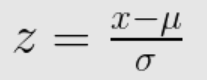

In [29]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
# Five fold cross-validation
def cross_val(model):
    #RMSE
    mae = cross_val_score(model,X_train, y_train,scoring="neg_mean_absolute_error", cv=5)
    mae = -mae
    mae_mean =mae.mean()
    mae_std = mae.std()
    # R2
    r2 = cross_val_score(model,X_train, y_train,scoring="r2", cv=5)
    r2_mean = r2.mean()
    r2_std = r2.std()
    return mae,mae_mean,mae_std,r2,r2_mean,r2_std

In [31]:
# Call the function and get the variables
mae_lgbm,mae_mean_lgbm,mae_std_lgbm, r2_lgbm,r2_mean_lgbm, r2_std_lgbm = cross_val(lgbm)
mae_gbr,mae_mean_gbr,mae_std_gbr, r2_gbr, r2_mean_gbr, r2_std_gbr = cross_val(gbr)

In [32]:
lbgm_mae_info = np.append(mae_lgbm,[mae_mean_lgbm,mae_std_lgbm])
lbgm_R2_info = np.append(r2_lgbm,[r2_mean_lgbm,r2_std_lgbm])

In [33]:
lbgm_df = pd.DataFrame([lbgm_mae_info,lbgm_R2_info],columns=[i+1 for i in range(len(lbgm_mae_info))])
lbgm_df

,1,2,3,4,5,6,7
0,7.51,6.73,7.01,6.25,7.29,6.96,0.44
1,0.88,0.91,0.88,0.91,0.88,0.89,0.02


In [34]:
lbgm_df.rename(index={0:'MAE',1:'R2'}, columns={6:'Avg',7:'std'})

,1,2,3,4,5,Avg,std
MAE,7.51,6.73,7.01,6.25,7.29,6.96,0.44
R2,0.88,0.91,0.88,0.91,0.88,0.89,0.02


In [35]:
# Put the five-fold cross-validations in dataframe
gbr_mae_info = np.append(mae_gbr,[mae_mean_gbr,mae_std_gbr])
gbr_R2_info = np.append(r2_gbr,[r2_mean_gbr,r2_std_gbr])

gbr_df = pd.DataFrame([gbr_mae_info,gbr_R2_info],columns=[i+1 for i in range(len(gbr_mae_info))])
gbr_df.rename(index={0:'MAE',1:'R2'}, columns={6:'Avg',7:'std'})

,1,2,3,4,5,Avg,std
MAE,7.52,6.74,7.01,6.10,7.21,6.92,0.48
R2,0.87,0.91,0.87,0.91,0.88,0.89,0.02


In [36]:
# Define search space
params = dict()
params['max_depth'] = (np.arange(2,8,1))
params['min_samples_split'] = (np.arange(2,5,1))
params['n_estimators'] = (np.arange(100,1000,100))
params['max_features'] = ("auto", "sqrt", "log2")

In [49]:
# define the Bayes search using Sklearn
# import skopt
# from skopt import gp_minimize
# from skopt import BayesSearchCV
# search = BayesSearchCV(estimator=lgbm, search_spaces=params,cv=10)
# # perform the search
# search.fit(X_train, y_train)
# #Print the best result
# print(search.best_score_)
# print(search.best_params_)

## Use the optimized parameters to predict test sets


In [37]:
# Define LGBMRegressor model
lgbm_opt =LGBMRegressor(max_depth=5,min_samples_split=4, n_estimators= 800,max_features='auto')

In [38]:
gbr_opt = HistGradientBoostingRegressor(learning_rate= 0.22)#learning_rate= 0.22

In [39]:
# Train the model and predict the yield using X_test 
lgbm_opt.fit(X_train, y_train)
lgbm_predict = lgbm_opt.predict(X_test)

# Train the model and predict the yield using X_test 
gbr_opt.fit(X_train, y_train)
gbr_predict = gbr_opt.predict(X_test)

In [40]:
# Take the average of the optimized predictions
ave_predict = (lgbm_predict + gbr_predict)/2

In [41]:
# Model performance using RMSE
MAE = mean_absolute_error(y_test, ave_predict)
print('MAE:', MAE)

MAE: 6.018595452254022


In [42]:
df_ = pd.DataFrame()

In [43]:
df_['Actual'] = np.array(y_test)
df_['Predicted'] = ave_predict

In [44]:
df_[:50]

,Actual,Predicted
0,189.29,186.54
1,199.23,196.58
2,169.53,170.42
3,219.88,221.23
4,211.16,204.48
5,179.70,186.83
6,177.46,180.88
7,193.01,198.10
8,253.85,256.82
9,174.26,178.09


In [45]:
# R^2 (coefficient of determination) regression score function: 
R2 =r2_score(y_test, ave_predict)
print('R^2:', R2)

R^2: 0.9185737403629818


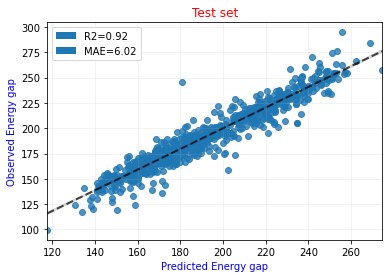

In [46]:
sn.regplot(x=ave_predict , y=y_test,line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7})
plt.xlabel('Predicted Energy gap', color='blue')
plt.ylabel('Observed Energy gap', color ='blue')
plt.title("Test set", color='red')
plt.grid(alpha=0.2)
R2 = mpatches.Patch(label="R2={:04.2f}".format(R2))
MAE = mpatches.Patch(label="MAE={:04.2f}".format(MAE))
plt.legend(handles=[R2, MAE])

## Save your model

In [47]:
import pickle
with open('lgbm_model.pkl','wb') as f:
          pickle.dump(lgbm_opt,f)
        
with open('hgbr_model.pkl','wb') as f:
          pickle.dump(gbr_opt,f)

##  Load your model

In [ ]:
# with open('lgbm_model.pkl','rb') as f:
#     model_lgbm = pickle.load(f)
        
# with open('hgbr_model.pkl','rb') as f:
#     model_hgbr = pickle.load(f)